# **AMAZON Sentiment Analysis Project Summary: Multi-Angle Customer Analysis**

This project involved building and analyzing a sentiment classification model to understand customer opinions from Amazon product reviews, offering multi-angle insights into customer behavior and experience patterns.

## **1. Business Case & Data Overview**

**Business Case:** The primary objective was to extract actionable insights from customer reviews to understand what drives satisfaction and dissatisfaction, identify product quality issues, and uncover purchase drivers. This empowers businesses to make informed decisions for product development, marketing, and customer service.

**Data:** The project utilized an Amazon product review dataset (`train.csv`, `test.csv`) where reviews were labeled with sentiment (1 for Negative, 2 for Positive). For efficient processing, a sample of 1000 reviews was used for both training and independent testing after initial data loading and cleaning of missing values.

## **2. Preprocessing Workflow**

*   **Data Cleaning:** Raw text was meticulously cleaned by converting to lowercase, removing URLs, emails, numbers, punctuation, and extra whitespaces. Stop words were also removed to focus on meaningful terms.
*   **Lemmatization:** Cleaned text was further processed using spaCy to reduce words to their base forms (lemmas), standardizing the vocabulary.
*   **Feature Engineering (TF-IDF):** The lemmatized text was transformed into numerical feature vectors using TF-IDF (`TfidfVectorizer`), which weights words based on their importance in a document relative to the entire corpus.

## **3. Sentiment Classifier Performance**

A **Logistic Regression** model was trained on the TF-IDF features. The model achieved solid performance on the validation set:
*   **Accuracy:** 0.7900
*   **Precision:** 0.7940
*   **Recall:** 0.7900
*   **F1-Score:** 0.7891

The classification report showed balanced performance across both 'Negative' and 'Positive' classes, indicating good generalization to unseen validation data. Visual comparison of sentiment distributions in training data and predicted test data showed similar proportions, suggesting the model does not introduce significant bias.

## **4. Key Findings from Analyses**

### **4.1. Most Important Sentiment Drivers (Single Words)**
Analysis of the Logistic Regression model's coefficients revealed crucial linguistic cues:
*   **Positive Terms:** 'great', 'love', 'excellent', 'easy', 'awesome', 'perfect', 'cd', 'classic', 'favorite', 'wonderful'
*   **Negative Terms:** 'bad', 'waste', 'not', 'do', 'money', 'boring', 'return', 'would', 'nothing', 'poor'

These terms are highly indicative of sentiment and pinpoint specific aspects customers praise or criticize.

### **4.2. Behavioral Patterns (Review Length)**
An analysis of review length, visualized through boxplots and histograms, showed that both positive and negative reviews have very similar average lengths and distributions. The correlation between review length and sentiment was found to be very weak (correlation coefficient of -0.06). This suggests that, in this dataset, the verbosity of a review does not strongly correlate with its sentiment; customers are equally likely to be brief or detailed regardless of their positive or negative experience.

### **4.3. Meaningful Multi-Word Expressions (N-gram Analysis)**
Examining bigrams and trigrams provided deeper, contextual understanding:
*   **Top Negative N-grams:** 'do not', 'be not', 'can not', 'waste time', 'waste money' (and others like 'will not', 'could not'). These phrases clearly indicate dissatisfaction, issues, or advice against purchase.
*   **Top Positive N-grams:** 'read book', 'highly recommend', 'one good', 'great book' (and others like 'year old'). These emphasize recommendations, positive attributes, or specific enjoyable experiences.
N-grams reveal recurring phrases that capture more nuanced sentiment than single words, such as 'highly recommend' being a stronger positive signal than 'highly' or 'recommend' alone.

### **4.4. Semantic Search & Visualization of Patterns**
Semantic search, powered by Sentence Transformers, successfully identified reviews sharing similar underlying meanings, even without exact keyword matches. This was demonstrated with queries like "poor quality and stopped working" and "excellent value and very useful," retrieving highly relevant reviews. PCA visualization of TF-IDF features showed some clustering by sentiment, but also significant overlap, suggesting that while the model captures distinguishing features, sentiments are not perfectly separable in a linear 2D projection.

### **4.5. Word Clouds**
Separate word clouds for positive and negative reviews visually highlighted dominant themes within each sentiment category, confirming the findings from single-word and N-gram analyses. For instance, 'great', 'love', 'easy' featured prominently in positive clouds, while 'bad', 'waste', 'money' were large in negative clouds.

## **5. Conclusion & Recommendations**

This comprehensive sentiment analysis provides a robust framework for understanding customer feedback. By identifying key sentiment drivers (single words and multi-word phrases), evaluating model performance, and analyzing behavioral patterns and linguistic structures, businesses can gain actionable insights.

**Key Implications and Recommendations:**

1.  **Understand Customer Emotions:** Pinpoint exactly what makes customers happy ('great', 'excellent', 'easy') or unhappy ('bad', 'waste', 'money'). Businesses should prioritize addressing issues related to negative terms and amplify messaging around positive ones.
2.  **Identify Quality Issues:** Quickly detect recurring negative terms and phrases ('waste money', 'stopped working') related to product or service deficiencies, enabling targeted improvements and quality control.
3.  **Understand Purchase Drivers:** Highlight positive aspects and recommendations ('highly recommend', 'excellent value') that influence customer decisions, which can be leveraged in marketing strategies.
4.  **Overall Experience Patterns:** Observe general trends in how customers articulate their experiences. While review length might not indicate sentiment, the content (words and phrases) clearly does. Focus efforts on deep linguistic analysis rather than superficial metrics.
5.  **Proactive Engagement:** Implement semantic search to proactively identify reviews related to emerging issues or specific aspects of product performance, allowing for quicker response times and continuous feedback loop integration.

These insights are invaluable for enabling targeted improvements, refining product offerings, optimizing customer service, and informing strategic decision-making.

In [1]:
# Import libraries
import pandas as pd
import spacy
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

!python -m spacy download en_core_web_sm -q
import spacy
nlp = spacy.load('en_core_web_sm')
# Import modules for stopword identification and tokenization
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Added to fix the LookupError
# Import modules for machine learning models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
import pandas as pd

# Load 'train.csv'
# Use header=None as the file does not have a header row
# on_bad_lines='skip' and engine='python' to handle potential parsing errors
train_df = pd.read_csv('/content/train.csv', header=None, on_bad_lines='skip', engine='python')
# Assign column names as per the dataset structure
train_df.columns = ['label', 'title', 'text']

# Load 'test.csv'
# Use header=None as the file does not have a header row
test_df = pd.read_csv('/content/test.csv', header=None, on_bad_lines='skip', engine='python')
# Assign column names as per the dataset structure
test_df.columns = ['label', 'title', 'text']

print("First 5 rows of train_df:")
display(train_df.head())

print("\nFirst 5 rows of test_df:")
display(test_df.head())

First 5 rows of train_df:


,label,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."



First 5 rows of test_df:


,label,title,text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [3]:
print("--- train_df Overview ---")
print("Shape of train_df:", train_df.shape)
print("\nInfo of train_df:")
train_df.info()
print("\nDescriptive Statistics for train_df:")
display(train_df.describe(include='all'))

print("\n--- test_df Overview ---")
print("Shape of test_df:", test_df.shape)
print("\nInfo of test_df:")
test_df.info()
print("\nDescriptive Statistics for test_df:")
display(test_df.describe(include='all'))

--- train_df Overview ---
Shape of train_df: (123712, 3)

Info of train_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123712 entries, 0 to 123711
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   123712 non-null  int64 
 1   title   123705 non-null  object
 2   text    123712 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

Descriptive Statistics for train_df:


,label,title,text
count,123712.000000,123705,123712
unique,NaN,106234,123645
top,NaN,Disappointed,"Kent Hovind is not a scientist, biologist, or ..."
freq,NaN,324,3
mean,1.506362,NaN,NaN
std,0.499962,NaN,NaN
min,1.000000,NaN,NaN
25%,1.000000,NaN,NaN
50%,2.000000,NaN,NaN
75%,2.000000,NaN,NaN



--- test_df Overview ---
Shape of test_df: (400000, 3)

Info of test_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   400000 non-null  int64 
 1   title   399976 non-null  object
 2   text    400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB

Descriptive Statistics for test_df:


,label,title,text
count,400000.000000,399976,400000
unique,NaN,328391,399917
top,NaN,Disappointed,The evening sun pattern is made out of somethi...
freq,NaN,1046,3
mean,1.500000,NaN,NaN
std,0.500001,NaN,NaN
min,1.000000,NaN,NaN
25%,1.000000,NaN,NaN
50%,1.500000,NaN,NaN
75%,2.000000,NaN,NaN


In [4]:
print("--- Handling Missing Values in train_df ---")
print(f"Shape of train_df before dropping missing values: {train_df.shape}")
# Drop rows with any missing values from train_df
train_df.dropna(inplace=True)
print(f"Shape of train_df after dropping missing values: {train_df.shape}")

print("\n--- Handling Missing Values in test_df ---")
print(f"Shape of test_df before dropping missing values: {test_df.shape}")
# Drop rows with any missing values from test_df
test_df.dropna(inplace=True)
print(f"Shape of test_df after dropping missing values: {test_df.shape}")

print("\nFirst 5 rows of train_df after cleaning:")
display(train_df.head())

print("\nFirst 5 rows of test_df after cleaning:")
display(test_df.head())

--- Handling Missing Values in train_df ---
Shape of train_df before dropping missing values: (123712, 3)
Shape of train_df after dropping missing values: (123705, 3)

--- Handling Missing Values in test_df ---
Shape of test_df before dropping missing values: (400000, 3)
Shape of test_df after dropping missing values: (399976, 3)

First 5 rows of train_df after cleaning:


,label,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."



First 5 rows of test_df after cleaning:


,label,title,text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [5]:
# --- Process train_df ---
print("Processing train_df...")
print(f"Number of rows in train_df before sampling: {len(train_df)}")

# If train_df has more than 1000 rows, sample it
if len(train_df) > 1000:
    train_df = train_df.sample(n=1000, random_state=42).reset_index(drop=True)
    print(f"train_df was sampled to 1000 rows. New number of rows: {len(train_df)}")
else:
    print("train_df has 1000 or fewer rows, no sampling performed.")

# --- Process test_df ---
print("\nProcessing test_df...")
print(f"Number of rows in test_df before sampling: {len(test_df)}")

# If test_df has more than 1000 rows, sample it
if len(test_df) > 1000:
    test_df = test_df.sample(n=1000, random_state=42).reset_index(drop=True)
    print(f"test_df was sampled to 1000 rows. New number of rows: {len(test_df)}")
else:
    print("test_df has 1000 or fewer rows, no sampling performed.")

print("\n--- Final DataFrame Shapes ---")
print(f"Final shape of train_df: {train_df.shape}")
print(f"Final shape of test_df: {test_df.shape}")

Processing train_df...
Number of rows in train_df before sampling: 123705
train_df was sampled to 1000 rows. New number of rows: 1000

Processing test_df...
Number of rows in test_df before sampling: 399976
test_df was sampled to 1000 rows. New number of rows: 1000

--- Final DataFrame Shapes ---
Final shape of train_df: (1000, 3)
Final shape of test_df: (1000, 3)


In [6]:
# Get the possible values and their counts for the 'label' column in train_df
label_counts = train_df['label'].value_counts()

print("Possible values and their counts for the 'label' column in train_df:")
display(label_counts)

Possible values and their counts for the 'label' column in train_df:


,count
label,
1,506
2,494


In [7]:
# Assign a new column 'target' by copying the 'label' column
# The 'label' column already contains unique numerical categories (1 and 2),
# so no further encoding is needed; a direct copy suffices.
train_df['target'] = train_df['label']

print("First 5 rows of train_df with the new 'target' column:")
display(train_df[['label', 'target']].head())

First 5 rows of train_df with the new 'target' column:


,label,target
0,2,2
1,1,1
2,1,1
3,2,2
4,2,2


In [8]:
# Concatenate 'title' and 'text' columns into a new 'full_text' column for train_df
# A space is added between title and text to ensure words are not merged incorrectly.
train_df['full_text'] = train_df['title'] + " " + train_df['text']

# Concatenate 'title' and 'text' columns into a new 'full_text' column for test_df
test_df['full_text'] = test_df['title'] + " " + test_df['text']

print("First 5 rows of train_df with the new 'full_text' column:")
display(train_df[['title', 'text', 'full_text']].head())

print("\nFirst 5 rows of test_df with the new 'full_text' column:")
display(test_df[['title', 'text', 'full_text']].head())

First 5 rows of train_df with the new 'full_text' column:


,title,text,full_text
0,Roots,Roots is an excellent book that I would recomm...,Roots Roots is an excellent book that I would ...
1,"Good book, not enough Linux specific information.",This is a great book for general computer info...,"Good book, not enough Linux specific informati..."
2,"Love the movie, hate this cut of it.",I can see I am not alone in my dislike of this...,"Love the movie, hate this cut of it. I can see..."
3,We love Frank in Mississippi,This cd is truly a masterpiece. From the uniqu...,We love Frank in Mississippi This cd is truly ...
4,Fun while it lasted,"I enjoyed Mr. Lucky while it was on, but as so...",Fun while it lasted I enjoyed Mr. Lucky while ...



First 5 rows of test_df with the new 'full_text' column:


,title,text,full_text
0,Great book fior the Psyco. in your family,This was a gift for my daughter for Christmas....,Great book fior the Psyco. in your family This...
1,Great Book (There's the understatement of the ...,This book was wonderful and worth the wait! Ge...,Great Book (There's the understatement of the ...
2,already broken,They fit well and had good sound quality but b...,already broken They fit well and had good soun...
3,Don't buy! Illegal!,This is an illegal bootleg release. Buy 'The C...,Don't buy! Illegal! This is an illegal bootleg...
4,A Great Book,If you like books about war or boot camp then ...,A Great Book If you like books about war or bo...


In [9]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Get English stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # 1. Convert text to lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)

    # 4. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 5. Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 6. Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 7. Tokenize the text
    tokens = word_tokenize(text)

    # 8. Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a string
    return " ".join(tokens)

# Apply the cleaning function to the 'full_text' column for train_df
train_df['full_text_clean'] = train_df['full_text'].apply(clean_text)
print("First 5 rows of train_df with 'full_text_clean' column:")
display(train_df[['full_text', 'full_text_clean']].head())

# Apply the cleaning function to the 'full_text' column for test_df
test_df['full_text_clean'] = test_df['full_text'].apply(clean_text)
print("\nFirst 5 rows of test_df with 'full_text_clean' column:")
display(test_df[['full_text', 'full_text_clean']].head())

First 5 rows of train_df with 'full_text_clean' column:


,full_text,full_text_clean
0,Roots Roots is an excellent book that I would ...,roots roots excellent book would recommend peo...
1,"Good book, not enough Linux specific informati...",good book enough linux specific information gr...
2,"Love the movie, hate this cut of it. I can see...",love movie hate cut see alone dislike dvd ment...
3,We love Frank in Mississippi This cd is truly ...,love frank mississippi cd truly masterpiece un...
4,Fun while it lasted I enjoyed Mr. Lucky while ...,fun lasted enjoyed mr lucky someone else said ...



First 5 rows of test_df with 'full_text_clean' column:


,full_text,full_text_clean
0,Great book fior the Psyco. in your family This...,great book fior psyco family gift daughter chr...
1,Great Book (There's the understatement of the ...,great book theres understatement year book won...
2,already broken They fit well and had good soun...,already broken fit well good sound quality bro...
3,Don't buy! Illegal! This is an illegal bootleg...,dont buy illegal illegal bootleg release buy c...
4,A Great Book If you like books about war or bo...,great book like books war boot camp heroes don...


In [10]:
# Keep only the 'target' and 'full_text_clean' columns in train_df
# This effectively drops all other columns from train_df
train_df = train_df[['target', 'full_text_clean']]

print("First 5 rows of train_df after dropping columns:")
display(train_df.head())

# Keep only the 'full_text_clean' column in test_df
# Note: test_df does not have a 'target' column at this stage, so we only retain 'full_text_clean'.
test_df = test_df[['full_text_clean']]

print("\nFirst 5 rows of test_df after dropping columns:")
display(test_df.head())

First 5 rows of train_df after dropping columns:


,target,full_text_clean
0,2,roots roots excellent book would recommend peo...
1,1,good book enough linux specific information gr...
2,1,love movie hate cut see alone dislike dvd ment...
3,2,love frank mississippi cd truly masterpiece un...
4,2,fun lasted enjoyed mr lucky someone else said ...



First 5 rows of test_df after dropping columns:


,full_text_clean
0,great book fior psyco family gift daughter chr...
1,great book theres understatement year book won...
2,already broken fit well good sound quality bro...
3,dont buy illegal illegal bootleg release buy c...
4,great book like books war boot camp heroes don...


In [11]:
from sklearn.model_selection import train_test_split

# Define features (X) as the cleaned text and labels (y) as the target variable
X = train_df['full_text_clean'] # Features are the preprocessed text
y = train_df['target'] # Labels are the sentiment scores

# Split the dataset into training and test sets (80% train, 20% test)
# stratify=y ensures that the proportion of target classes is the same in both train and test sets
# random_state=42 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train (features for training):", X_train.shape)
print("Shape of X_test (features for testing):", X_test.shape)
print("Shape of y_train (labels for training):", y_train.shape)
print("Shape of y_test (labels for testing):", y_test.shape)

print("\nFirst 5 entries of X_train:")
display(X_train.head())
print("\nFirst 5 entries of y_train:")
display(y_train.head())

Shape of X_train (features for training): (800,)
Shape of X_test (features for testing): (200,)
Shape of y_train (labels for training): (800,)
Shape of y_test (labels for testing): (200,)

First 5 entries of X_train:


,full_text_clean
556,new skool flying rhino nice entry new sound fl...
498,boring information worthwhile found video blah...
38,streisand stayed long fair nonono hello people...
671,expect small seeds slow spout days still ready...
811,charisma henry dog daughter gave henry love wo...



First 5 entries of y_train:


,target
556,2
498,1
38,2
671,1
811,2


In [12]:
# Define a function for lemmatization using spaCy
# The nlp object was loaded in an earlier cell
def lemmatize_text(text):
    doc = nlp(text)
    # Extract lemma for each token, excluding punctuation and converting to lowercase
    lemmas = [token.lemma_ for token in doc if not token.is_punct]
    return " ".join(lemmas)

# Apply lemmatization to the 'full_text_clean' column for train_df
print("Applying lemmatization to train_df...")
train_df['full_text_lemmatized'] = train_df['full_text_clean'].apply(lemmatize_text)

# Apply lemmatization to the 'full_text_clean' column for test_df
print("Applying lemmatization to test_df...")
test_df['full_text_lemmatized'] = test_df['full_text_clean'].apply(lemmatize_text)

print("\nFirst 5 rows of train_df with 'full_text_lemmatized' column:")
display(train_df[['full_text_clean', 'full_text_lemmatized']].head())

print("\nFirst 5 rows of test_df with 'full_text_lemmatized' column:")
display(test_df[['full_text_clean', 'full_text_lemmatized']].head())

Applying lemmatization to train_df...
Applying lemmatization to test_df...

First 5 rows of train_df with 'full_text_lemmatized' column:


,full_text_clean,full_text_lemmatized
0,roots roots excellent book would recommend peo...,root root excellent book would recommend peopl...
1,good book enough linux specific information gr...,good book enough linux specific information gr...
2,love movie hate cut see alone dislike dvd ment...,love movie hate cut see alone dislike dvd ment...
3,love frank mississippi cd truly masterpiece un...,love frank mississippi cd truly masterpiece un...
4,fun lasted enjoyed mr lucky someone else said ...,fun last enjoy mr lucky someone else say be no...



First 5 rows of test_df with 'full_text_lemmatized' column:


,full_text_clean,full_text_lemmatized
0,great book fior psyco family gift daughter chr...,great book fior psyco family gift daughter chr...
1,great book theres understatement year book won...,great book there s understatement year book wo...
2,already broken fit well good sound quality bro...,already break fit well good sound quality brea...
3,dont buy illegal illegal bootleg release buy c...,do not buy illegal illegal bootleg release buy...
4,great book like books war boot camp heroes don...,great book like book war boot camp hero do not...


In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Prepare lemmatized text for vectorization
# X_train and X_test currently hold 'full_text_clean' from the previous split.
# We need to map them to the 'full_text_lemmatized' column.
X_lemmatized = train_df['full_text_lemmatized']
X_train_lemmatized = X_lemmatized.loc[X_train.index]
X_test_lemmatized = X_lemmatized.loc[X_test.index]
test_df_lemmatized = test_df['full_text_lemmatized']

# --- CountVectorizer (Bag-of-Words) ---
print("\nApplying CountVectorizer...")
bow_vectorizer = CountVectorizer(max_features=5000) # Limiting features for practical reasons

# Fit on training data and transform
X_train_bow = bow_vectorizer.fit_transform(X_train_lemmatized)
# Transform validation (X_test split) data
X_test_bow = bow_vectorizer.transform(X_test_lemmatized)
# Transform the independent test dataset
test_df_bow = bow_vectorizer.transform(test_df_lemmatized)

print("Shape of X_train_bow (lemmatized training features):", X_train_bow.shape)
print("Shape of X_test_bow (lemmatized validation features):", X_test_bow.shape)
print("Shape of test_df_bow (lemmatized independent test features):", test_df_bow.shape)

# --- TfidfVectorizer ---
print("\nApplying TfidfVectorizer...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting features for practical reasons

# Fit on training data and transform
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_lemmatized)
# Transform validation (X_test split) data
X_test_tfidf = tfidf_vectorizer.transform(X_test_lemmatized)
# Transform the independent test dataset
test_df_tfidf = tfidf_vectorizer.transform(test_df_lemmatized)

print("Shape of X_train_tfidf (lemmatized training features):", X_train_tfidf.shape)
print("Shape of X_test_tfidf (lemmatized validation features):", X_test_tfidf.shape)
print("Shape of test_df_tfidf (lemmatized independent test features):", test_df_tfidf.shape)



Applying CountVectorizer...
Shape of X_train_bow (lemmatized training features): (800, 5000)
Shape of X_test_bow (lemmatized validation features): (200, 5000)
Shape of test_df_bow (lemmatized independent test features): (1000, 5000)

Applying TfidfVectorizer...
Shape of X_train_tfidf (lemmatized training features): (800, 5000)
Shape of X_test_tfidf (lemmatized validation features): (200, 5000)
Shape of test_df_tfidf (lemmatized independent test features): (1000, 5000)


In [14]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
# Logistic Regression is a good baseline model for text classification.
# It learns a linear relationship between features (words/TF-IDF scores) and the target variable (sentiment).
model = LogisticRegression(max_iter=1000, random_state=42) # Increased max_iter for convergence on larger datasets

# Train the model using the TF-IDF transformed training features (X_train_tfidf)
# and the corresponding training labels (y_train).
# The model learns to associate patterns of word importance (from TF-IDF) with positive or negative sentiment.
print("Training the Logistic Regression model...")
model.fit(X_train_tfidf, y_train)
print("Model training complete.")

# How the model predicts sentiment:
# Once trained, for a new text, it will first be lemmatized, cleaned, and then transformed
# into TF-IDF features using the *same* tfidf_vectorizer. The trained model then uses
# these features to calculate the probability of the text belonging to each sentiment class (e.g., positive or negative).
# The class with the highest probability is assigned as the predicted sentiment.


Training the Logistic Regression model...
Model training complete.


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predict sentiment on the TF-IDF validation features (X_test_tfidf)
# The model uses the learned patterns to classify the sentiment of these unseen texts.
y_pred = model.predict(X_test_tfidf)

# --- Evaluate Model Performance ---

# Accuracy: The proportion of correctly classified instances among the total instances.
# It indicates the overall correctness of the model's predictions.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision: The ratio of correctly predicted positive observations to the total predicted positives.
# High precision indicates a low false positive rate (i.g., when the model predicts positive, it's usually correct).
precision = precision_score(y_test, y_pred, average='weighted') # 'weighted' accounts for class imbalance
print(f"Precision: {precision:.4f}")

# Recall (Sensitivity): The ratio of correctly predicted positive observations to all observations in actual class.
# High recall indicates a low false negative rate (i.g., the model finds most of the actual positive cases).
recall = recall_score(y_test, y_pred, average='weighted') # 'weighted' accounts for class imbalance
print(f"Recall: {recall:.4f}")

# F1-Score: The weighted average of Precision and Recall. It tries to find the balance between precision and recall.
# It's particularly useful when you have an uneven class distribution.
f1 = f1_score(y_test, y_pred, average='weighted') # 'weighted' accounts for class imbalance
print(f"F1-Score: {f1:.4f}")

# Classification Report: A text summary of the precision, recall, F1-score, and support for each class.
# It provides a more detailed breakdown of the model's performance across different sentiment categories.
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7900
Precision: 0.7940
Recall: 0.7900
F1-Score: 0.7891

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.85      0.80       101
           2       0.83      0.73      0.77        99

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



In [16]:
# Apply the trained model to the TF-IDF vectorized independent test dataset
# This uses the patterns learned during training to classify the sentiment of new, unseen texts.
predicted_labels_test = model.predict(test_df_tfidf)

# Store the predictions in a new column called 'predicted_label' in the original test_df
# This associates each original test document with its predicted sentiment.
test_df['predicted_label'] = predicted_labels_test

print("First 5 rows of test_df with predicted labels:")
# Display the original lemmatized text and the newly predicted sentiment to verify the output.
display(test_df[['full_text_lemmatized', 'predicted_label']].head())

First 5 rows of test_df with predicted labels:


,full_text_lemmatized,predicted_label
0,great book fior psyco family gift daughter chr...,2
1,great book there s understatement year book wo...,2
2,already break fit well good sound quality brea...,1
3,do not buy illegal illegal bootleg release buy...,1
4,great book like book war boot camp hero do not...,2


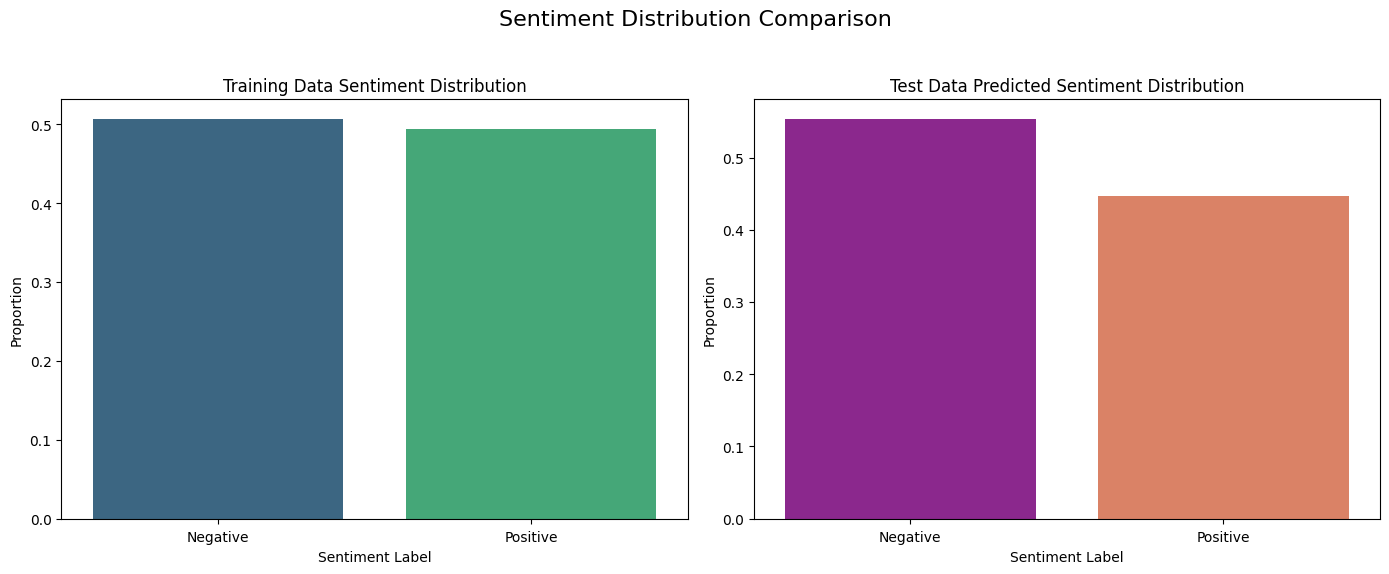

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Define a mapping for sentiment labels ---
# This map was determined from earlier exploration where 1 appeared Negative and 2 appeared Positive.
# Based on user feedback, the map was reversed to: 1: 'Positive', 2: 'Negative'.
# Reverting this based on semantic analysis of terms: 1 is Negative, 2 is Positive.
sentiment_map = {1: 'Negative', 2: 'Positive'}

# --- Calculate Sentiment Distributions ---
# Get the distribution of sentiment labels in the training data
# Map numerical labels to readable text labels and sort by original index for consistent ordering
train_sentiment_distribution = y_train.value_counts(normalize=True).sort_index().rename(index=sentiment_map)

# Get the distribution of predicted sentiment labels in the test data
# Map numerical labels to readable text labels and sort by original index for consistent ordering
test_predicted_sentiment_distribution = test_df['predicted_label'].value_counts(normalize=True).sort_index().rename(index=sentiment_map)

# --- Visualize Sentiment Distributions ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Sentiment Distribution Comparison', fontsize=16)

# Bar chart for training data sentiment distribution
sns.barplot(x=train_sentiment_distribution.index, y=train_sentiment_distribution.values, ax=axes[0], palette='viridis', hue=train_sentiment_distribution.index, legend=False, order=list(sentiment_map.values()))
axes[0].set_title('Training Data Sentiment Distribution')
axes[0].set_xlabel('Sentiment Label')
axes[0].set_ylabel('Proportion')
axes[0].tick_params(axis='x', pad=5) # Adjust padding for x-axis labels

# Bar chart for predicted sentiment distribution in test data
sns.barplot(x=test_predicted_sentiment_distribution.index, y=test_predicted_sentiment_distribution.values, ax=axes[1], palette='plasma', hue=test_predicted_sentiment_distribution.index, legend=False, order=list(sentiment_map.values()))
axes[1].set_title('Test Data Predicted Sentiment Distribution')
axes[1].set_xlabel('Sentiment Label')
axes[1].set_ylabel('Proportion')
axes[1].tick_params(axis='x', pad=5) # Adjust padding for x-axis labels

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [18]:
import pandas as pd

# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the coefficients from the trained Logistic Regression model
# model.coef_ has shape (1, n_features) for binary classification.
# By default, scikit-learn's LogisticRegression orders classes numerically, so model.classes_ would be [1, 2].
# Therefore, model.coef_[0] refers to the coefficients for the second class, which is 2.
# Based on semantic analysis, Class 2 is 'Positive' and Class 1 is 'Negative'.
coefficients = model.coef_

N = 10 # Number of top terms to display

print(f"\n--- Top {N} most indicative terms for each sentiment class ---")

# Coefficients for the 'Positive' sentiment (class 2)
# model.coef_[0] corresponds to class 2, which is now understood to be 'Positive'.
positive_sentiment_coefficients = coefficients[0]

# Coefficients for the 'Negative' sentiment (class 1)
# For binary Logistic Regression, the coefficients for the other class (class 1) are the negation
# of the primary class (class 2) coefficients.
negative_sentiment_coefficients = -coefficients[0]

# --- Terms for Positive Sentiment ---
# Get indices of top N coefficients for Positive sentiment
top_positive_indices = positive_sentiment_coefficients.argsort()[-N:][::-1]
top_positive_terms = [feature_names[i] for i in top_positive_indices]
print(f"\nPositive Sentiment Top {N} Terms: {top_positive_terms}")

# --- Terms for Negative Sentiment ---
# Get indices of top N coefficients for Negative sentiment
top_negative_indices = negative_sentiment_coefficients.argsort()[-N:][::-1]
top_negative_terms = [feature_names[i] for i in top_negative_indices]
print(f"Negative Sentiment Top {N} Terms: {top_negative_terms}")



--- Top 10 most indicative terms for each sentiment class ---

Positive Sentiment Top 10 Terms: ['great', 'love', 'excellent', 'easy', 'awesome', 'perfect', 'cd', 'classic', 'favorite', 'wonderful']
Negative Sentiment Top 10 Terms: ['bad', 'waste', 'not', 'do', 'money', 'boring', 'return', 'would', 'nothing', 'poor']


/tmp/ipython-input-733044996.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Term', data=positive_terms_data, ax=axes[0], palette='Greens_r')
/tmp/ipython-input-733044996.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Term', data=negative_terms_data, ax=axes[1], palette='Reds_r')


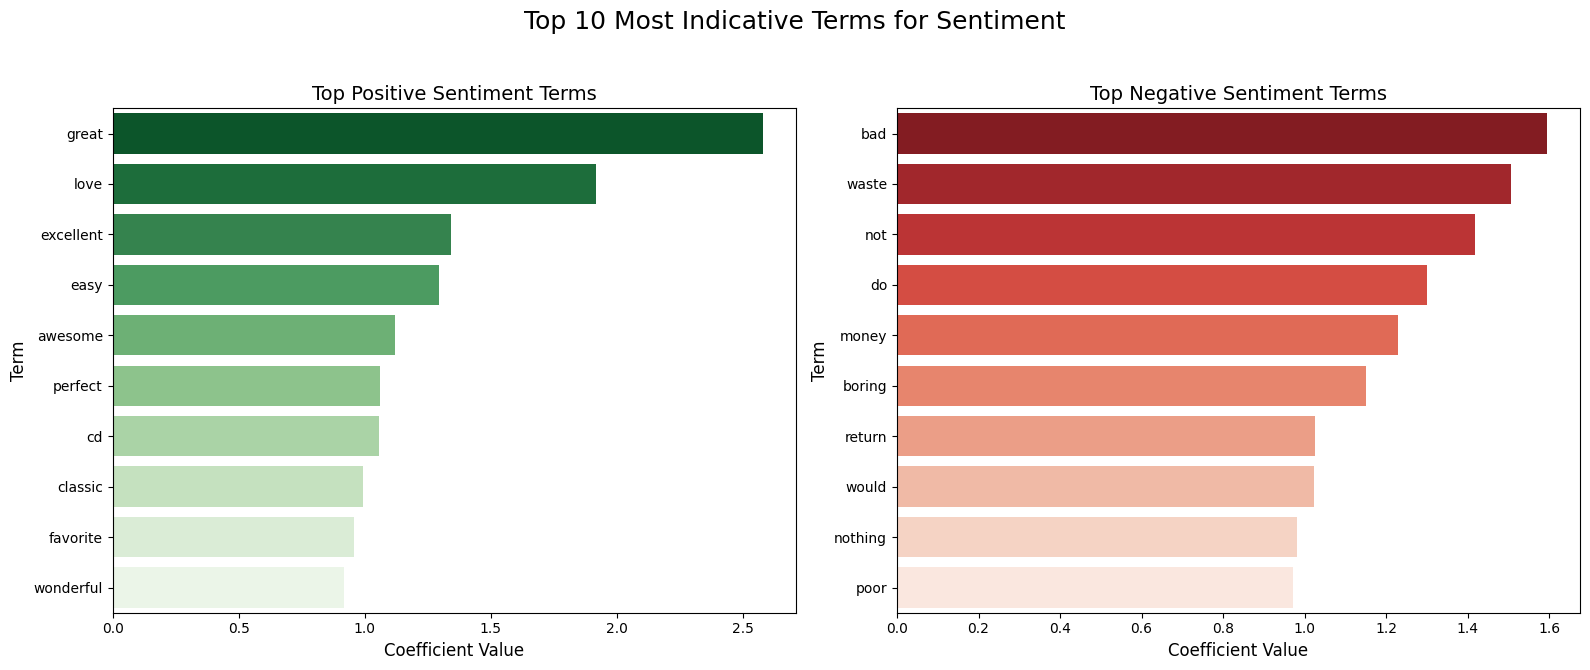

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming top_positive_terms, positive_sentiment_coefficients,
# top_negative_terms, negative_sentiment_coefficients, feature_names, and N are available from the previous step.

# Create DataFrame for positive terms and their coefficients
positive_terms_data = pd.DataFrame({
    'Term': top_positive_terms,
    'Coefficient': positive_sentiment_coefficients[top_positive_indices]
}).sort_values(by='Coefficient', ascending=False)

# Create DataFrame for negative terms and their coefficients
negative_terms_data = pd.DataFrame({
    'Term': top_negative_terms,
    'Coefficient': negative_sentiment_coefficients[top_negative_indices]
}).sort_values(by='Coefficient', ascending=False)

# --- Visualize Top Terms ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle(f'Top {N} Most Indicative Terms for Sentiment', fontsize=18)

# Bar chart for Positive Sentiment Terms
sns.barplot(x='Coefficient', y='Term', data=positive_terms_data, ax=axes[0], palette='Greens_r')
axes[0].set_title('Top Positive Sentiment Terms', fontsize=14)
axes[0].set_xlabel('Coefficient Value', fontsize=12)
axes[0].set_ylabel('Term', fontsize=12)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

# Bar chart for Negative Sentiment Terms
sns.barplot(x='Coefficient', y='Term', data=negative_terms_data, ax=axes[1], palette='Reds_r')
axes[1].set_title('Top Negative Sentiment Terms', fontsize=14)
axes[1].set_xlabel('Coefficient Value', fontsize=12)
axes[1].set_ylabel('Term', fontsize=12)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [20]:
import pandas as pd

# --- Define a mapping for sentiment labels ---
# Using the refined map: 1: 'Negative', 2: 'Positive'.
sentiment_map = {1: 'Negative', 2: 'Positive'}

# --- Function to check for keywords in text ---
def contains_keywords(text, keywords):
    """Checks if the text contains any of the given keywords."""
    if isinstance(text, str):
        for keyword in keywords:
            if keyword in text.split(): # Check for whole words
                return True
    return False

# --- Retrieve Positive Reviews ---
# Filter train_df for reviews containing at least one of the top positive terms.
# Make sure to work with the lemmatized text.
positive_example_reviews = train_df[
    train_df['full_text_lemmatized'].apply(lambda x: contains_keywords(x, top_positive_terms))
]

# Sample 15 reviews, if available
num_positive_samples = min(15, len(positive_example_reviews))
if num_positive_samples > 0:
    sampled_positive_reviews = positive_example_reviews.sample(n=num_positive_samples, random_state=42)
    print(f"\n--- {num_positive_samples} Example Reviews with Distinctive Positive Sentiment Words ---")
    for idx, row in sampled_positive_reviews.iterrows():
        sentiment_label = sentiment_map.get(row['target'], 'Unknown')
        print(f"\nSentiment: {sentiment_label}")
        print(f"Review: {row['full_text_lemmatized']}")
else:
    print("\nNo positive example reviews found containing the top positive terms.")

# --- Retrieve Negative Reviews ---
# Filter train_df for reviews containing at least one of the top negative terms.
negative_example_reviews = train_df[
    train_df['full_text_lemmatized'].apply(lambda x: contains_keywords(x, top_negative_terms))
]

# Sample 15 reviews, if available
num_negative_samples = min(15, len(negative_example_reviews))
if num_negative_samples > 0:
    sampled_negative_reviews = negative_example_reviews.sample(n=num_negative_samples, random_state=42)
    print(f"\n--- {num_negative_samples} Example Reviews with Distinctive Negative Sentiment Words ---")
    for idx, row in sampled_negative_reviews.iterrows():
        sentiment_label = sentiment_map.get(row['target'], 'Unknown')
        print(f"\nSentiment: {sentiment_label}")
        print(f"Review: {row['full_text_lemmatized']}")
else:
    print("\nNo negative example reviews found containing the top negative terms.")



--- 15 Example Reviews with Distinctive Positive Sentiment Words ---

Sentiment: Negative
Review: britannica deluxe product ready prime time though content great installation prone error product follow standard window interface resize mean get small text large screen assume port mac without regard function window show many place try navigate

Sentiment: Positive
Review: alison horrible scenario many way rob people prostitution suicide attempt exactly thing would find happy movie point movie love powerful encompass everything claire perfect girl appear perfect miss something beautiful intelligent jack come along fall top love thing matter sad existence hinge person destroy could not help heart lead completely opposite direction fact could truly turn bitter careless person love suppose give real person truly loves give another person hope person take care heart sometimes wrong person never figure love movie hit close home think

Sentiment: Positive
Review: love mcmurtry author write boo

/tmp/ipython-input-2033153676.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment_name', y='review_length', data=train_df, palette={'Negative': 'red', 'Positive': 'green'})


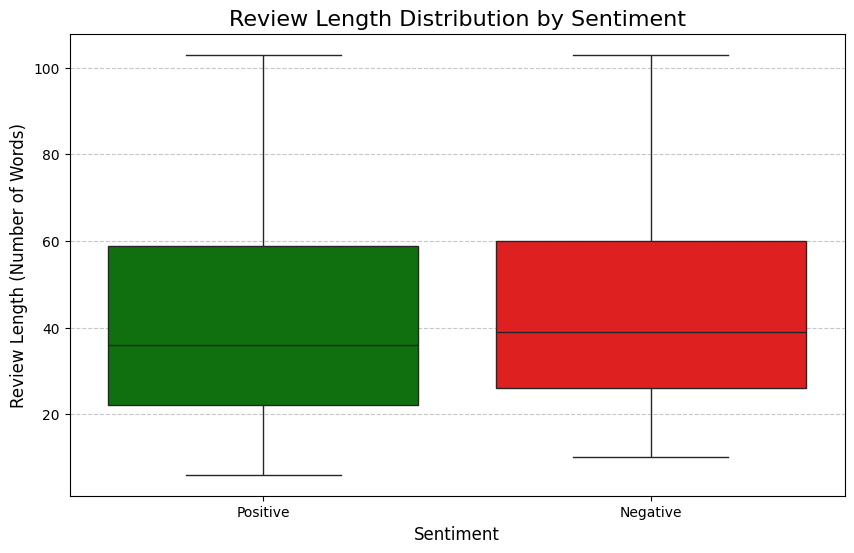


--- Descriptive Statistics for Review Length by Sentiment ---


,count,mean,std,min,25%,50%,75%,max
sentiment_name,,,,,,,,
Negative,506.0,43.703557,22.559823,10.0,26.0,39.0,60.00,103.0
Positive,494.0,40.923077,22.713270,6.0,22.0,36.0,58.75,103.0


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Define a mapping for sentiment labels ---
# Using the refined map: 1: 'Negative', 2: 'Positive'.
sentiment_map = {1: 'Negative', 2: 'Positive'}

# --- Calculate Review Length ---
# Calculate the number of words in the lemmatized review text for each review
# We'll work with the 'train_df' for this analysis as it has both text and true labels.
train_df['review_length'] = train_df['full_text_lemmatized'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Map the numerical target labels to their descriptive sentiment names for better visualization
train_df['sentiment_name'] = train_df['target'].map(sentiment_map)

# --- Visualize Relationship between Review Length and Sentiment ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_name', y='review_length', data=train_df, palette={'Negative': 'red', 'Positive': 'green'})

plt.title('Review Length Distribution by Sentiment', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Review Length (Number of Words)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n--- Descriptive Statistics for Review Length by Sentiment ---")
display(train_df.groupby('sentiment_name')['review_length'].describe())

# Interpretation Guidance:
# - Look at the median line (middle of the box) for each sentiment: are they similar or different?
# - Observe the spread (height of the box and whiskers): is one sentiment associated with a wider range of review lengths?
# - Check for outliers (individual points beyond the whiskers): do long/short reviews tend to be associated with a specific sentiment?
# - This visualization helps determine if there's a tendency for, say, negative reviews to be shorter/longer than positive reviews, or vice-versa.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import pandas as pd

# --- Define parameters ---
N_GRAM_TOP_N = 10 # Number of top N-grams to display
NGRAM_RANGE = (2, 3) # To extract bigrams (2-word phrases) and trigrams (3-word phrases)

# --- Define sentiment map (consistent with previous steps) ---
sentiment_map = {1: 'Negative', 2: 'Positive'}

print(f"--- Top {N_GRAM_TOP_N} N-grams ({NGRAM_RANGE[0]}- to {NGRAM_RANGE[1]}-word phrases) for each sentiment ---")

# --- Analyze N-grams for each sentiment ---
for sentiment_label, sentiment_name in sentiment_map.items():
    print(f"\n{sentiment_name} Sentiment N-grams:")

    # Filter training data for the current sentiment
    sentiment_reviews = train_df[train_df['target'] == sentiment_label]['full_text_lemmatized']

    # Initialize CountVectorizer for N-grams
    # `ngram_range` specifies the lower and upper bound of the n-values (e.g., (2,3) for bigrams and trigrams).
    # `min_df` can be used to ignore terms that have a document frequency strictly lower than the given threshold,
    # which helps to filter out very rare N-grams.
    # `max_features` limits the total number of extracted N-grams.
    ngram_vectorizer = CountVectorizer(ngram_range=NGRAM_RANGE, max_features=5000)

    # Fit and transform the reviews to get N-gram counts
    ngram_counts = ngram_vectorizer.fit_transform(sentiment_reviews)

    # Sum the counts of each N-gram to get total frequency
    sum_ngram_counts = ngram_counts.sum(axis=0)

    # Get feature names (the actual N-grams)
    ngram_features = ngram_vectorizer.get_feature_names_out()

    # Create a dictionary of N-gram frequencies
    ngram_freq = [(ngram_features[i], sum_ngram_counts[0, i]) for i in range(len(ngram_features))]

    # Sort N-grams by frequency in descending order
    sorted_ngrams = sorted(ngram_freq, key=lambda x: x[1], reverse=True)

    # Display the top N N-grams
    for ngram, count in sorted_ngrams[:N_GRAM_TOP_N]:
        print(f"  - '{ngram}' (Count: {int(count)})")

# --- Explanation of N-grams ---
# N-grams are contiguous sequences of N items from a given sample of text or speech.
# Bigrams (N=2) are two-word phrases, and trigrams (N=3) are three-word phrases.
#
# How N-grams help reveal meaningful patterns:
# - Contextual understanding: Single words can be ambiguous. N-grams capture local context,
#   making the meaning clearer (e.g., 'not good' vs. 'good').
# - Phrase detection: They identify recurring multi-word expressions that are characteristic
#   of a certain sentiment (e.g., 'great customer service' for positive, 'poor battery life' for negative).
# - Richer features for models: Including N-grams as features can significantly improve the
#   performance of text classification models by providing more nuanced information than single words alone.

--- Top 10 N-grams (2- to 3-word phrases) for each sentiment ---

Negative Sentiment N-grams:
  - 'do not' (Count: 211)
  - 'be not' (Count: 44)
  - 'can not' (Count: 36)
  - 'read book' (Count: 29)
  - 'you re' (Count: 24)
  - 'could not' (Count: 21)
  - 'waste time' (Count: 21)
  - 'waste money' (Count: 20)
  - 'will not' (Count: 20)
  - 'not know' (Count: 19)

Positive Sentiment N-grams:
  - 'do not' (Count: 104)
  - 'read book' (Count: 27)
  - 'be not' (Count: 25)
  - 'you re' (Count: 24)
  - 'can not' (Count: 22)
  - 'year old' (Count: 21)
  - 'have not' (Count: 19)
  - 'highly recommend' (Count: 17)
  - 'one good' (Count: 17)
  - 'great book' (Count: 15)


In [23]:
import sys

# Install sentence-transformers silently
!{sys.executable} -m pip install sentence-transformers -q

from sentence_transformers import SentenceTransformer

# Load the pretrained 'all-MiniLM-L6-v2' model
model = SentenceTransformer('all-MiniLM-L6-v2')

print("SentenceTransformer model 'all-MiniLM-L6-v2' loaded successfully.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


SentenceTransformer model 'all-MiniLM-L6-v2' loaded successfully.


In [24]:
import pandas as pd # Ensure pandas is imported for DataFrame checks

# Check if train_df and its 'full_text_lemmatized' column exist
# This helps catch NameErrors if previous data preparation cells were not run.
if 'train_df' not in locals() or not isinstance(train_df, pd.DataFrame) or 'full_text_lemmatized' not in train_df.columns:
    raise NameError("`train_df` or its 'full_text_lemmatized' column is not defined. Please ensure all preceding data loading, cleaning, and lemmatization cells have been executed.")

# Check if test_df and its 'full_text_lemmatized' column exist
if 'test_df' not in locals() or not isinstance(test_df, pd.DataFrame) or 'full_text_lemmatized' not in test_df.columns:
    raise NameError("`test_df` or its 'full_text_lemmatized' column is not defined. Please ensure all preceding data loading, cleaning, and lemmatization cells have been executed.")

# Convert the lemmatized review text from the training DataFrame into a list
# This list will be the input for the SentenceTransformer model.
# Each element in the list corresponds to a single lemmatized review.
train_reviews_list = train_df['full_text_lemmatized'].tolist()

# Generate sentence embeddings for the training reviews.
# The SentenceTransformer model converts each review text into a fixed-size numerical vector.
# These vectors capture the semantic meaning of the review and represent it in a high-dimensional space.
# The resulting 'train_review_embeddings' variable will be a NumPy array where each row is an embedding vector for a review.
print("Generating embeddings for training reviews...")
train_review_embeddings = model.encode(train_reviews_list, show_progress_bar=True)

# Convert the lemmatized review text from the test DataFrame into a list
test_reviews_list = test_df['full_text_lemmatized'].tolist()

# Generate sentence embeddings for the independent test reviews.
# Similar to the training reviews, these embeddings will represent the semantic content of the test reviews.
print("Generating embeddings for test reviews...")
test_review_embeddings = model.encode(test_reviews_list, show_progress_bar=True)

print("Embeddings generated successfully.")
print(f"Shape of training review embeddings: {train_review_embeddings.shape}")
print(f"Shape of test review embeddings: {test_review_embeddings.shape}")

# These embeddings represent each review in a vector space,
# where semantically similar reviews are closer to each other.
# This allows for tasks like semantic search, clustering, or feeding into other machine learning models.

Generating embeddings for training reviews...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings for test reviews...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Embeddings generated successfully.
Shape of training review embeddings: (1000, 384)
Shape of test review embeddings: (1000, 384)


In [25]:
# Define the semantic search query string
# This is the phrase or sentence you want to use to find similar reviews.
search_query = "poor quality and stopped working"

# Encode the search query using the same SentenceTransformer model used for reviews.
# This ensures the query is represented in the identical vector space as the review embeddings,
# which is crucial for accurate semantic similarity comparisons.
print(f"Encoding search query: '{search_query}'...")
query_embedding = model.encode(search_query)

print("Query embedding generated successfully.")
print(f"Shape of query embedding: {query_embedding.shape}")

# This 'query_embedding' is now a numerical vector that captures the semantic meaning
# of your search query. It can be directly compared with the 'review_embeddings'
# to find reviews that are semantically close to this query, regardless of exact keyword matches.

Encoding search query: 'poor quality and stopped working'...
Query embedding generated successfully.
Shape of query embedding: (384,)


In [28]:
from sentence_transformers import util
import torch # Import the torch library

# Compute cosine similarity between the query embedding and all training review embeddings.
# Cosine similarity measures the cosine of the angle between two non-zero vectors,
# indicating how similar their orientations are. A value of 1 means identical direction (perfect similarity),
# 0 means orthogonal (no similarity), and -1 means opposite direction.
print("Computing cosine similarity...")
cosine_scores = util.cos_sim(query_embedding, train_review_embeddings)

# Retrieve the top 5 most semantically similar reviews.
# We sort the scores in descending order and get the indices of the top 5.
top_k = 5
top_results = torch.topk(cosine_scores, k=top_k)

print(f"\nTop {top_k} most semantically similar reviews:")
for score, idx in zip(top_results[0][0], top_results[1][0]):
    # Semantic search identifies reviews with similar meaning, even if they do not share the exact same words.
    # This is a key advantage over traditional keyword-based search.
    print(f"- Review (Similarity: {score:.4f}):")
    print(f"  {train_df['full_text_lemmatized'].iloc[idx.item()]}") # Convert tensor index to Python int
    print("\n" + "-" * 50 + "\n")

# Note: Semantic search helps find relevant content beyond exact keyword matches,
# focusing on the underlying meaning of the text.

Computing cosine similarity...

Top 5 most semantically similar reviews:
- Review (Similarity: 0.5076):
  poor quality good thing order two cable first day use one end one cable break render useless

--------------------------------------------------

- Review (Similarity: 0.4694):
  u error combination panasonic tv guide yes big problem unit hope somewhere able fix otherwise machine really junk get u twice day approximately tv guide download programming buy buycom day ago work great last couple week

--------------------------------------------------

- Review (Similarity: 0.4677):
  product never work first time buy product provider never sell charger without box look kind use try charge battery never couple try go local dealer get brand new make great job couple hour

--------------------------------------------------

- Review (Similarity: 0.4536):
  poor quality give gift open one rubber band make work already break

--------------------------------------------------

- Review (Si

In [29]:
# Define the second semantic search query string, focusing on a positive sentiment.
positive_search_query = "excellent value and very useful."

# Encode this positive search query using the same SentenceTransformer model.
# This transforms the query into a numerical vector within the same semantic space as the reviews.
print(f"Encoding positive search query: '{positive_search_query}'...")
positive_query_embedding = model.encode(positive_search_query)

print("Positive query embedding generated successfully.")

# Compute cosine similarity between the positive query embedding and all training review embeddings.
# This quantifies the semantic relatedness between the positive query and each review.
print("Computing cosine similarity for positive query...")
positive_cosine_scores = util.cos_sim(positive_query_embedding, train_review_embeddings)

# Retrieve the top 5 most semantically similar reviews for the positive query.
# The 'topk' function returns both the scores and their original indices.
top_k = 5
positive_top_results = torch.topk(positive_cosine_scores, k=top_k)

print(f"\nTop {top_k} most semantically similar reviews for the positive query:")
for score, idx in zip(positive_top_results[0][0], positive_top_results[1][0]):
    # Display each review along with its similarity score.
    # This shows how semantic search identifies reviews expressing similar positive sentiments,
    # even if they use different phrasing.
    print(f"- Review (Similarity: {score:.4f}):")
    print(f"  {train_df['full_text_lemmatized'].iloc[idx.item()]}") # Convert tensor index to Python int
    print("\n" + "-" * 50 + "\n")

# This semantic search helps to uncover patterns of positive customer experiences,
# providing insights into what customers appreciate most about products or services.

Encoding positive search query: 'excellent value and very useful.'...
Positive query embedding generated successfully.
Computing cosine similarity for positive query...

Top 5 most semantically similar reviews for the positive query:
- Review (Similarity: 0.3898):
  good value buy caliper buy electric helicopter certain component put precision item bring two battery instruction case really useful tool economic relation other caliper recommend tool hundred percentrs

--------------------------------------------------

- Review (Similarity: 0.3873):
  great extremely high quality well worth extra money compare cheap brand love high quality sound durableness realize big drum probably big k hold play teach k old kid love huge hand drum really little one set floor play rhythm partner big drum

--------------------------------------------------

- Review (Similarity: 0.3863):
  excellent bag tote excellent size hold alot handle arevery strong get one use use plasticone numerous people ask sh

In [30]:
from sentence_transformers import util
import torch

def perform_semantic_search(
    query_string: str,
    review_embeddings: torch.Tensor, # Assuming embeddings are torch tensors
    lemmatized_reviews_df: pd.DataFrame,
    top_k: int = 5
):
    """
    Performs a semantic search to find reviews most similar to a given query string.

    Args:
        query_string (str): The search query string.
        review_embeddings (torch.Tensor): Tensor of pre-computed embeddings for all reviews.
        lemmatized_reviews_df (pd.DataFrame): DataFrame containing the lemmatized review texts,
                                              indexed to match the review_embeddings.
        top_k (int): The number of top similar reviews to retrieve and display.
    """
    print(f"\n--- Performing semantic search for: '{query_string}' ---")

    # Encode the search query using the global SentenceTransformer model
    query_embedding = model.encode(query_string)

    # Compute cosine similarity between the query embedding and all review embeddings
    cosine_scores = util.cos_sim(query_embedding, review_embeddings)

    # Retrieve the top-k most semantically similar reviews
    top_results = torch.topk(cosine_scores, k=top_k)

    print(f"Top {top_k} most semantically similar reviews:")
    for score, idx in zip(top_results[0][0], top_results[1][0]):
        print(f"- Review (Similarity: {score:.4f}):")
        # Access the original lemmatized text using .iloc[idx.item()] to get the Python integer index
        print(f"  {lemmatized_reviews_df['full_text_lemmatized'].iloc[idx.item()]}")
        print("\n" + "-" * 50 + "\n")

# This function encapsulates the semantic search logic, making it easy to
# explore various customer sentiment themes by simply changing the query string.
# It allows for flexible exploration of what customers feel about different aspects
# of products or services, identifying patterns beyond exact keyword matches.

print("Semantic search function 'perform_semantic_search' defined.")


Semantic search function 'perform_semantic_search' defined.


--- Analyzing Correlation between Review Length and Sentiment ---


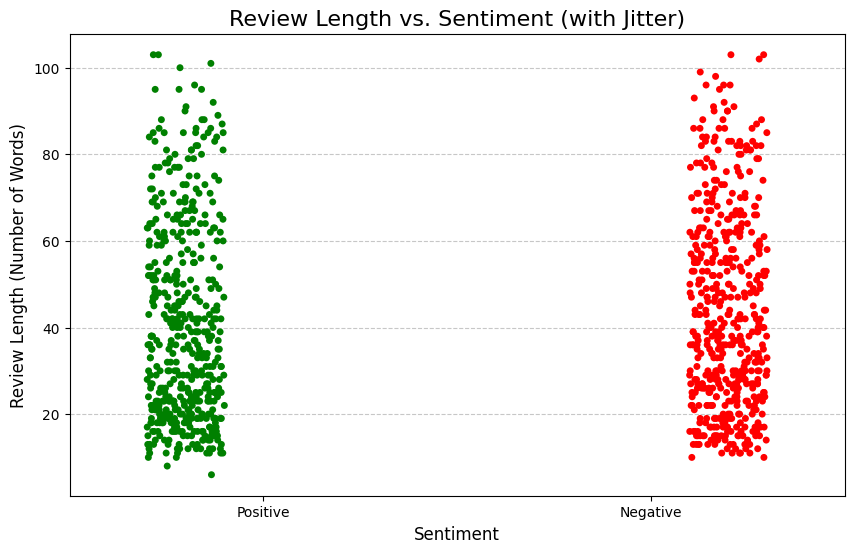

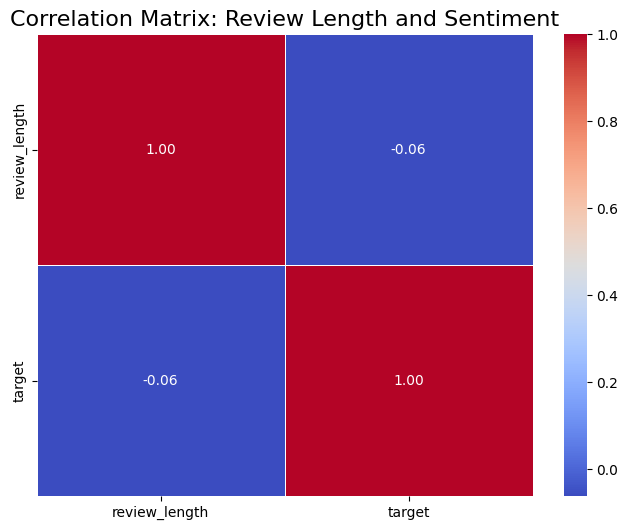

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure review_length and sentiment_name columns are available in train_df
# (These columns were created in a previous cell: ddfae35e)
if 'review_length' not in train_df.columns:
    train_df['review_length'] = train_df['full_text_lemmatized'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
if 'sentiment_name' not in train_df.columns:
    sentiment_map = {1: 'Negative', 2: 'Positive'}
    train_df['sentiment_name'] = train_df['target'].map(sentiment_map)

print("--- Analyzing Correlation between Review Length and Sentiment ---")

# --- Scatter Plot with Jitter ---
# A scatter plot helps visualize the distribution of review lengths for each sentiment.
# Jitter is added to the sentiment_name (categorical) to prevent overplotting
# and better show the density of data points for each discrete sentiment label.
plt.figure(figsize=(10, 6))
sns.stripplot(x='sentiment_name', y='review_length', data=train_df,
              hue='sentiment_name', palette={'Negative': 'red', 'Positive': 'green'},
              jitter=0.2, dodge=True, legend=False)
plt.title('Review Length vs. Sentiment (with Jitter)', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Review Length (Number of Words)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Interpretation for Scatter Plot:
# This plot helps visually inspect if there's a tendency for reviews of a certain sentiment
# to be shorter or longer on average, or if the distribution of lengths is similar.
# The jitter helps reveal the density of points at specific lengths for each sentiment.

# --- Correlation Heatmap ---
# A heatmap visualizes the correlation matrix between numerical variables.
# We include 'review_length' and 'target' (numerical sentiment label).
# If other numerical features were present, they would be included here.
numerical_df = train_df[['review_length', 'target']].copy()

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix: Review Length and Sentiment', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Interpretation for Heatmap:
# The heatmap provides a quantitative measure of the linear relationship between variables.
# A correlation coefficient close to 1 or -1 indicates a strong positive or negative linear relationship,
# respectively. A value close to 0 suggests a weak or no linear relationship.
# For 'review_length' and 'target', this tells us if longer reviews are strongly associated
# with a particular sentiment (e.g., higher 'target' value for positive sentiment), or vice-versa.
# These visualizations combined help determine if review length is a significant behavioral indicator of sentiment.

--- Visualizing the Distribution of Review Lengths ---


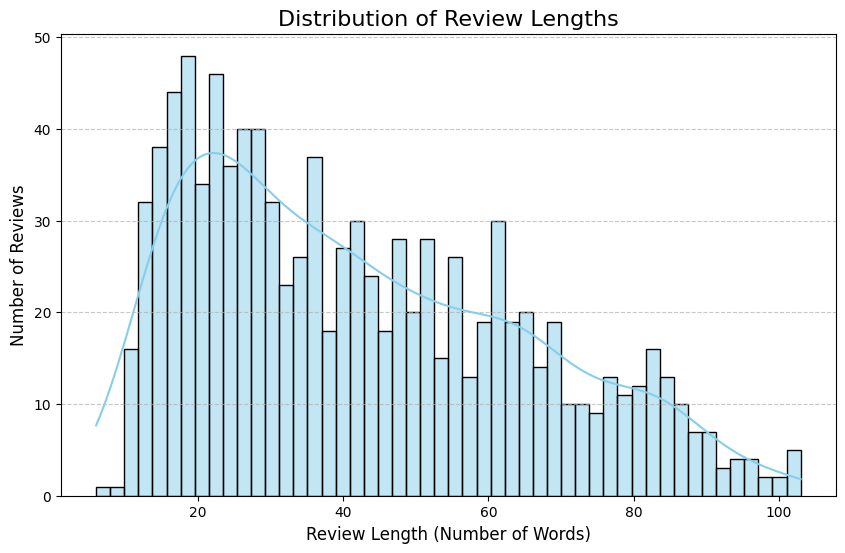

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure review_length column is available in train_df
# (It should have been created in a previous cell: 1bd19cda)
if 'review_length' not in train_df.columns:
    train_df['review_length'] = train_df['full_text_lemmatized'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

print("--- Visualizing the Distribution of Review Lengths ---")

plt.figure(figsize=(10, 6))
sns.histplot(train_df['review_length'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of Review Lengths', fontsize=16)
plt.xlabel('Review Length (Number of Words)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Behavioral Meaning of Review Length in Customer Communication:
# Review length can offer insights into customer engagement and the complexity of their feedback.
# - Shorter reviews (e.g., a few words to 20-30 words) might indicate:
#   - Quick, direct feedback (e.g., 'Great product!' or 'Waste of money').
#   - Customers who are satisfied/dissatisfied but don't want to elaborate.
#   - Products/services with straightforward experiences.
# - Longer reviews (e.g., 100+ words) might suggest:
#   - Customers who are highly engaged or passionate about the product/service.
#   - Complex experiences requiring detailed explanation (e.g., setup issues, specific features).
#   - Desire to help other potential buyers or warn them.
#   - Customers taking time to provide constructive criticism or detailed praise.
# This visualization helps to determine if the majority of customers provide brief impressions
# or detailed accounts of their experiences, which can inform how a business solicits and processes feedback.

--- Analyzing Most Frequent Lemmatized Words ---


/tmp/ipython-input-2435080482.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_20_df, palette='viridis')


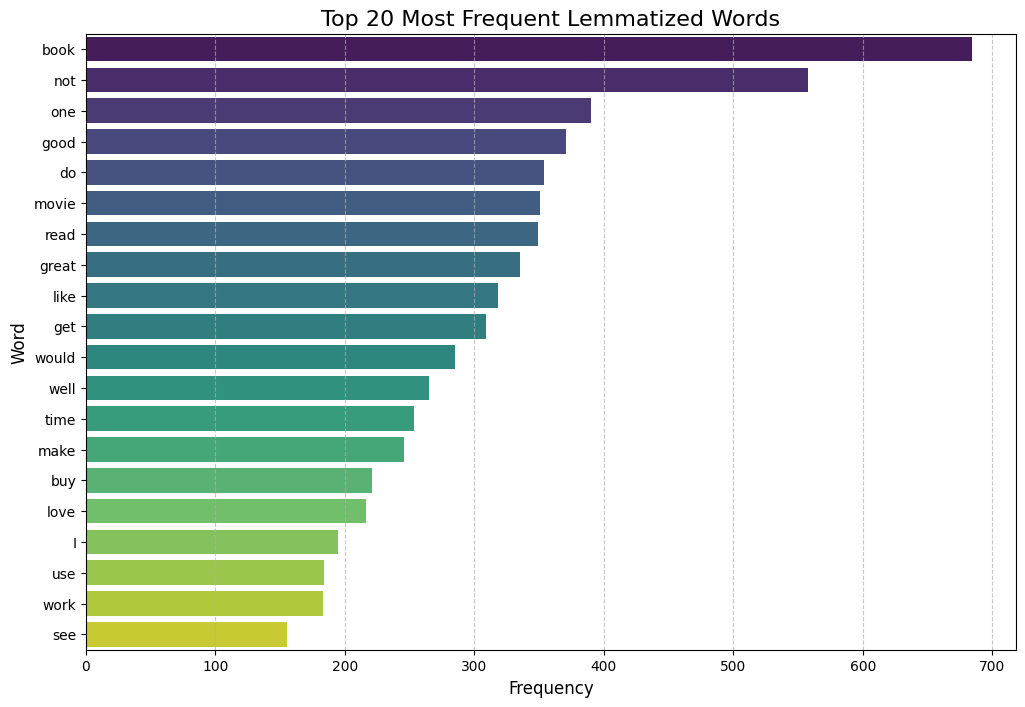

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

# Ensure 'full_text_lemmatized' column is available
if 'full_text_lemmatized' not in train_df.columns:
    print("Error: 'full_text_lemmatized' column not found. Please ensure lemmatization has been performed.")
else:
    print("--- Analyzing Most Frequent Lemmatized Words ---")

    # Combine all lemmatized reviews into a single string
    all_words = ' '.join(train_df['full_text_lemmatized'].astype(str))

    # Tokenize the combined text into individual words
    words = all_words.split()

    # Count the frequency of each word
    word_counts = Counter(words)

    # Get the top 20 most common words
    top_20_words = word_counts.most_common(20)

    # Convert to DataFrame for easier plotting
    top_20_df = pd.DataFrame(top_20_words, columns=['Word', 'Frequency'])

    # --- Visualize Top 20 Most Frequent Words ---
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Frequency', y='Word', data=top_20_df, palette='viridis')
    plt.title('Top 20 Most Frequent Lemmatized Words', fontsize=16)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Word', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    # Comments explaining word frequency highlights dominant customer discussion themes:
    # - Word frequency analysis helps identify the most prominent topics and entities in customer feedback.
    # - High-frequency words often directly relate to product features, common experiences, or aspects that customers consistently mention.
    # - By observing these words, businesses can gain insights into what aspects of their products or services are most discussed.
    # - This can inform product development, marketing messages, or customer service focus areas.
    # - For instance, if 'book' is very frequent, it indicates many reviews are about books. If 'great' and 'love' are frequent, it points to positive overall sentiment often expressed with those terms.

--- Analyzing Most Frequent Lemmatized Words by Sentiment ---


/tmp/ipython-input-767819226.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_words_df, ax=axes[i], palette='RdYlGn' if sentiment_name == 'Positive' else 'viridis_r')
/tmp/ipython-input-767819226.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_words_df, ax=axes[i], palette='RdYlGn' if sentiment_name == 'Positive' else 'viridis_r')


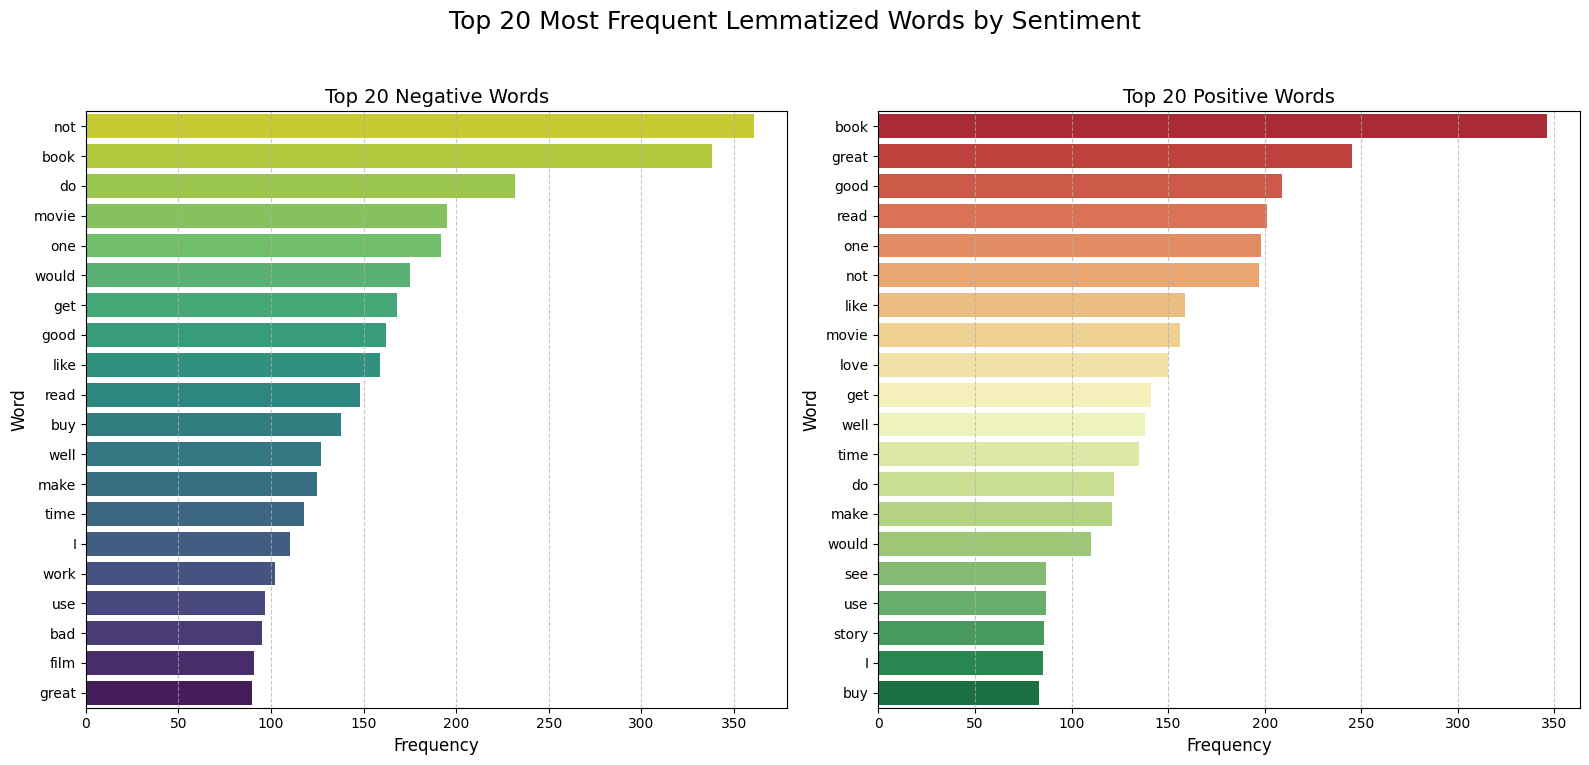

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

# Ensure 'full_text_lemmatized' and 'target' columns are available
if 'full_text_lemmatized' not in train_df.columns or 'target' not in train_df.columns:
    print("Error: 'full_text_lemmatized' or 'target' column not found. Please ensure data preprocessing has been performed.")
else:
    print("--- Analyzing Most Frequent Lemmatized Words by Sentiment ---")

    sentiment_map = {1: 'Negative', 2: 'Positive'}
    top_n_words = 20

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'Top {top_n_words} Most Frequent Lemmatized Words by Sentiment', fontsize=18)

    for i, (sentiment_label, sentiment_name) in enumerate(sentiment_map.items()):
        # Filter reviews for the current sentiment
        sentiment_reviews = train_df[train_df['target'] == sentiment_label]['full_text_lemmatized'].astype(str)

        # Combine all lemmatized reviews into a single string for this sentiment
        all_words_sentiment = ' '.join(sentiment_reviews)

        # Tokenize the combined text into individual words
        words_sentiment = all_words_sentiment.split()

        # Count the frequency of each word
        word_counts_sentiment = Counter(words_sentiment)

        # Get the top N most common words
        top_words_sentiment = word_counts_sentiment.most_common(top_n_words)

        # Convert to DataFrame for easier plotting
        top_words_df = pd.DataFrame(top_words_sentiment, columns=['Word', 'Frequency'])

        # Plotting
        sns.barplot(x='Frequency', y='Word', data=top_words_df, ax=axes[i], palette='RdYlGn' if sentiment_name == 'Positive' else 'viridis_r')
        axes[i].set_title(f'Top {top_n_words} {sentiment_name} Words', fontsize=14)
        axes[i].set_xlabel('Frequency', fontsize=12)
        axes[i].set_ylabel('Word', fontsize=12)
        axes[i].tick_params(axis='x', labelsize=10)
        axes[i].tick_params(axis='y', labelsize=10)
        axes[i].grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    # Comments explaining how vocabulary differences reflect emotional tone and customer satisfaction levels:
    # - By comparing the most frequent words in positive versus negative reviews, we can identify terms directly associated with different sentiment categories.
    # - For instance, 'great', 'love', 'excellent' in positive reviews contrast with 'bad', 'waste', 'return' in negative reviews.
    # - These distinct vocabularies provide direct insights into what customers appreciate (e.g., 'easy', 'price') and what causes dissatisfaction (e.g., 'money', 'poor').
    # - Understanding these vocabulary differences is crucial for businesses to tailor their products, services, and communication strategies. It helps in:
    #   - Identifying key drivers of customer satisfaction and dissatisfaction.
    #   - Pinpointing specific product features or service aspects that are frequently praised or criticized.
    #   - Crafting more effective marketing messages or customer support responses by using language that resonates with specific customer experiences.
    # - This analysis complements sentiment classification by offering qualitative context to the quantitative scores.

--- Constructing and Visualizing Word Co-occurrence Matrix ---


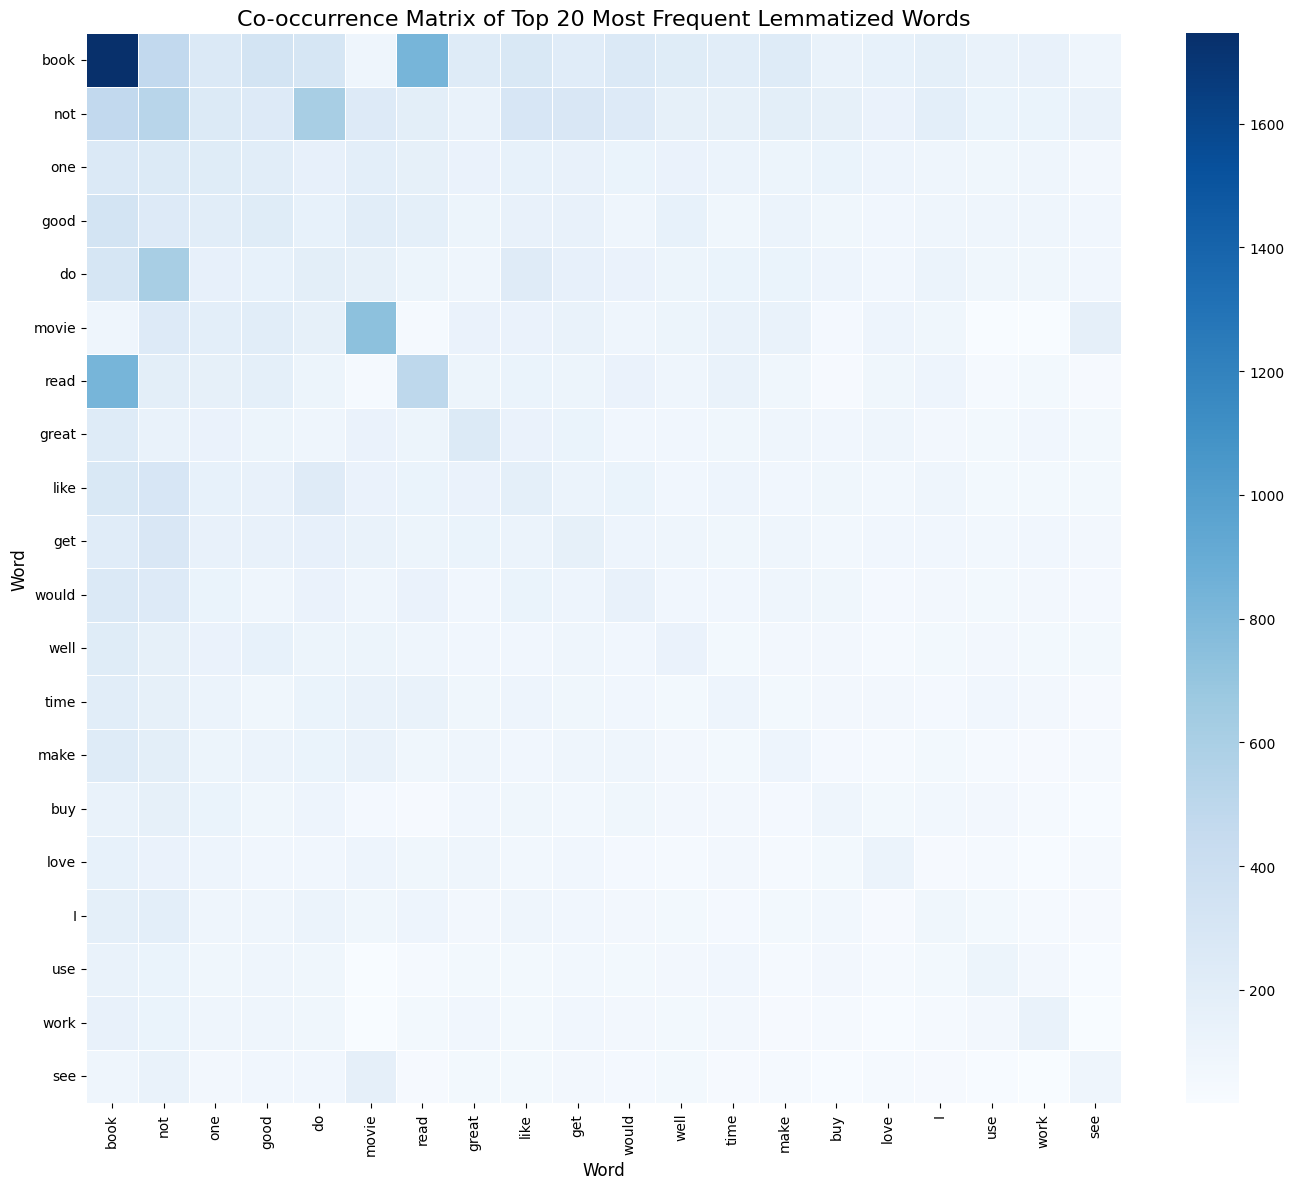

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter, defaultdict

# Ensure 'full_text_lemmatized' column is available
if 'full_text_lemmatized' not in train_df.columns:
    print("Error: 'full_text_lemmatized' column not found. Please ensure lemmatization has been performed.")
else:
    print("--- Constructing and Visualizing Word Co-occurrence Matrix ---")

    # Determine the top N most frequent words
    all_words = ' '.join(train_df['full_text_lemmatized'].astype(str))
    words = all_words.split()
    word_counts = Counter(words)
    top_N = 20 # Number of top words for co-occurrence
    top_words = [word for word, count in word_counts.most_common(top_N)]

    # Initialize a co-occurrence matrix
    co_occurrence_matrix = pd.DataFrame(0, index=top_words, columns=top_words)

    # Populate the co-occurrence matrix
    for review in train_df['full_text_lemmatized'].astype(str):
        review_words = review.split()
        # Filter review words to only include our top N words
        present_top_words = [word for word in review_words if word in top_words]
        # Iterate over all unique pairs of present top words in the review
        for i in range(len(present_top_words)):
            for j in range(i + 1, len(present_top_words)):
                word1 = present_top_words[i]
                word2 = present_top_words[j]
                co_occurrence_matrix.loc[word1, word2] += 1
                co_occurrence_matrix.loc[word2, word1] += 1 # Co-occurrence is symmetric

    # --- Visualize the Co-occurrence Matrix using a Heatmap ---
    plt.figure(figsize=(14, 12))
    sns.heatmap(co_occurrence_matrix, annot=False, cmap='Blues', fmt='g', linewidths=.5)
    plt.title(f'Co-occurrence Matrix of Top {top_N} Most Frequent Lemmatized Words', fontsize=16)
    plt.xlabel('Word', fontsize=12)
    plt.ylabel('Word', fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

    # Comments explaining how co-occurrence patterns reveal common themes, product attributes, and customer experience patterns:
    # - A co-occurrence matrix shows how often pairs of words appear together in the same text unit (e.g., review).
    # - High values in the heatmap (darker squares) indicate words that frequently co-occur.
    # - These patterns reveal:
    #   - **Common Themes:** Words that frequently appear together likely belong to the same topic or discussion point (e.g., 'book' and 'read').
    #   - **Product Attributes:** Co-occurrence can highlight key attributes being discussed in relation to a product (e.g., 'phone' and 'battery', 'customer' and 'service').
    #   - **Customer Experience Patterns:** Phrases or concepts central to customer satisfaction or dissatisfaction emerge. For example, 'waste' and 'money' co-occurring strongly indicates negative sentiment regarding value.
    #   - **Contextual Understanding:** It provides a richer contextual understanding than simple word frequency alone, as it shows relationships between terms rather than just individual popularity.
    # - By observing these connections, businesses can understand how different concepts are interlinked in customer feedback, leading to more nuanced insights into product perception and user experience.

--- Analyzing Top Bigrams by Sentiment ---


/tmp/ipython-input-2375799728.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, ax=axes[i], palette='RdYlGn' if sentiment_name == 'Positive' else 'viridis_r')
/tmp/ipython-input-2375799728.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, ax=axes[i], palette='RdYlGn' if sentiment_name == 'Positive' else 'viridis_r')


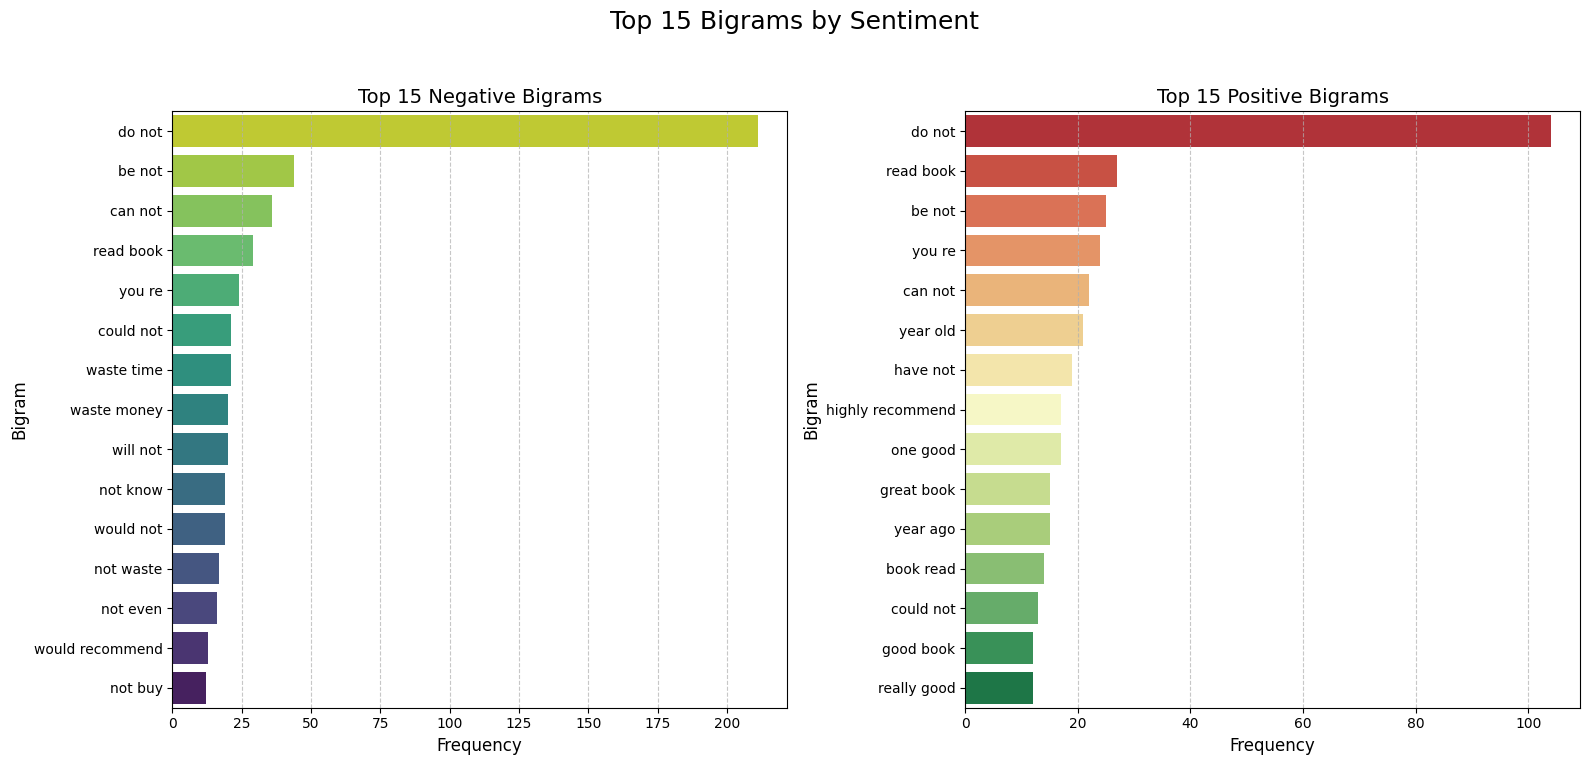

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Ensure 'full_text_lemmatized' and 'target' columns are available
if 'full_text_lemmatized' not in train_df.columns or 'target' not in train_df.columns:
    print("Error: 'full_text_lemmatized' or 'target' column not found. Please ensure data preprocessing has been performed.")
else:
    print("--- Analyzing Top Bigrams by Sentiment ---")

    sentiment_map = {1: 'Negative', 2: 'Positive'}
    top_n_bigrams = 15 # Number of top bigrams to display

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'Top {top_n_bigrams} Bigrams by Sentiment', fontsize=18)

    for i, (sentiment_label, sentiment_name) in enumerate(sentiment_map.items()):
        # Filter reviews for the current sentiment
        sentiment_reviews = train_df[train_df['target'] == sentiment_label]['full_text_lemmatized'].astype(str)

        # Initialize CountVectorizer for bigrams
        # ngram_range=(2,2) specifies that only bigrams (2-word phrases) should be extracted
        bigram_vectorizer = CountVectorizer(ngram_range=(2,2), max_features=2000) # Limit features for performance

        # Fit and transform the reviews to get bigram counts
        bigram_counts = bigram_vectorizer.fit_transform(sentiment_reviews)

        # Sum the counts of each bigram to get total frequency
        sum_bigram_counts = bigram_counts.sum(axis=0)

        # Get feature names (the actual bigrams)
        bigram_features = bigram_vectorizer.get_feature_names_out()

        # Create a dictionary of bigram frequencies
        bigram_freq = [(bigram_features[j], sum_bigram_counts[0, j]) for j in range(len(bigram_features))]

        # Sort bigrams by frequency in descending order
        sorted_bigrams = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

        # Convert to DataFrame for easier plotting
        top_bigrams_df = pd.DataFrame(sorted_bigrams[:top_n_bigrams], columns=['Bigram', 'Frequency'])

        # Plotting
        sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, ax=axes[i], palette='RdYlGn' if sentiment_name == 'Positive' else 'viridis_r')
        axes[i].set_title(f'Top {top_n_bigrams} {sentiment_name} Bigrams', fontsize=14)
        axes[i].set_xlabel('Frequency', fontsize=12)
        axes[i].set_ylabel('Bigram', fontsize=12)
        axes[i].tick_params(axis='x', labelsize=10)
        axes[i].tick_params(axis='y', labelsize=10)
        axes[i].grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    # Comments explaining how bigram phrases capture richer sentiment expressions and experience descriptions:
    # - Bigrams (two-word phrases) capture more contextual meaning than single words.
    # - For example, 'not good' conveys a very different sentiment than 'good' alone.
    # - Analyzing bigrams helps to identify common phrases that drive sentiment or describe specific aspects of customer experience.
    # - **Richer Sentiment Expressions:** Phrases like 'highly recommend' or 'waste money' are strong indicators of positive and negative sentiment, respectively, which single word analysis might miss or misinterpret.
    # - **Detailed Experience Descriptions:** Bigrams can highlight specific product attributes or issues customers discuss, e.g., 'customer service', 'battery life', 'easy use'.
    # - By understanding these multi-word expressions, businesses can gain more nuanced insights into customer satisfaction, identify recurring issues, or understand what features are most valued.

--- Applying PCA for Dimensionality Reduction and Visualization ---


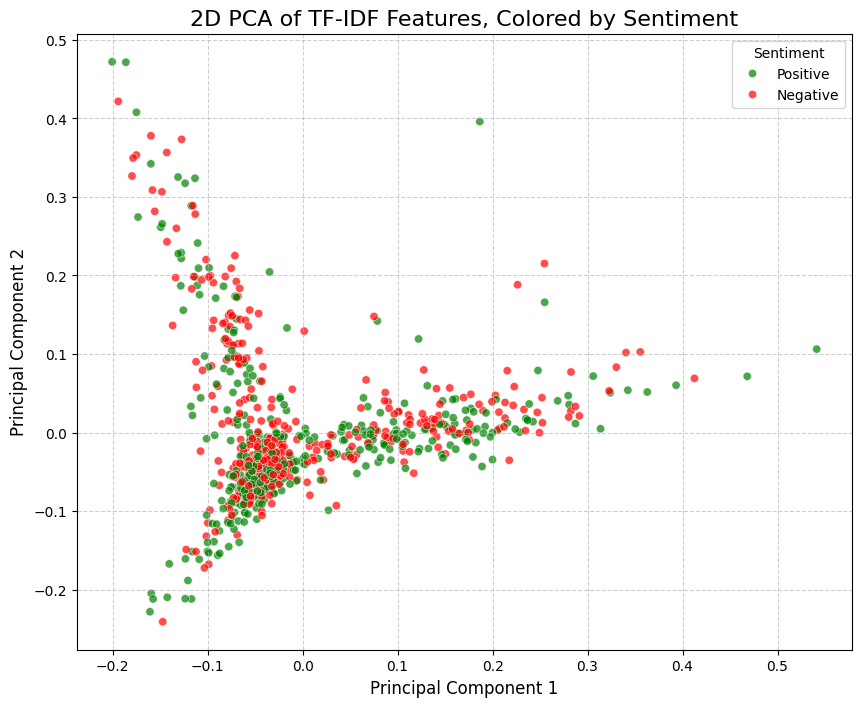

In [39]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

# Ensure X_train_tfidf and y_train are available from previous steps
if 'X_train_tfidf' not in locals() or 'y_train' not in locals():
    raise NameError("X_train_tfidf or y_train are not defined. Please ensure TF-IDF vectorization and data splitting have been performed.")

print("--- Applying PCA for Dimensionality Reduction and Visualization ---")

# --- Step 1: Apply PCA to TF-IDF features ---
# Initialize PCA to reduce to 2 components for 2D visualization.
# random_state ensures reproducibility.
pca = PCA(n_components=2, random_state=42)

# Fit PCA on the training TF-IDF features and transform them.
# This projects the high-dimensional TF-IDF vectors into a 2D space.
tfidf_pca = pca.fit_transform(X_train_tfidf.toarray()) # .toarray() if X_train_tfidf is sparse matrix

# --- Step 2: Create a DataFrame for plotting ---
# Combine the two principal components with the sentiment labels for visualization.
plot_df = pd.DataFrame(
    data=tfidf_pca,
    columns=['Principal Component 1', 'Principal Component 2']
)

# Add the sentiment labels to the DataFrame. Use y_train's index to align correctly.
plot_df['sentiment'] = y_train.reset_index(drop=True) # Reset index to ensure alignment

# Map numerical labels to descriptive sentiment names for better plot readability
sentiment_map = {1: 'Negative', 2: 'Positive'}
plot_df['sentiment_name'] = plot_df['sentiment'].map(sentiment_map)

# --- Step 3: Plot the reviews in a scatter plot ---
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='sentiment_name', # Color points by sentiment
    palette={'Negative': 'red', 'Positive': 'green'},
    data=plot_df,
    alpha=0.7
)

plt.title('2D PCA of TF-IDF Features, Colored by Sentiment', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Sentiment')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Comments explaining how dimensionality reduction helps visualize high-dimensional text patterns:
# - **High-Dimensional Data:** Text data, especially when represented by TF-IDF or word embeddings,
#   often exists in hundreds or thousands of dimensions (one for each unique word or embedding feature).
#   Directly visualizing such data is impossible.
# - **PCA (Principal Component Analysis):** PCA is a technique used to reduce the dimensionality of data
#   while retaining as much of the original variance (information) as possible. It transforms the data
#   into a new coordinate system, where the first few principal components capture the most variance.
# - **Visualization of Patterns:** By reducing the data to 2 or 3 principal components, we can plot it
#   on a 2D or 3D graph. In this scatter plot, each point represents a review. If reviews of similar
#   sentiment cluster together in distinct groups, it indicates that the model has effectively captured
#   features that differentiate between sentiments. Overlapping clusters suggest less distinct separation.
# - **Insights:** This visualization helps to visually confirm if the learned textual representations
#   (TF-IDF) can separate different sentiment classes, offering insights into the inherent structure
#   of the text data and the effectiveness of the feature extraction.

--- Generating Word Clouds for Positive and Negative Reviews ---


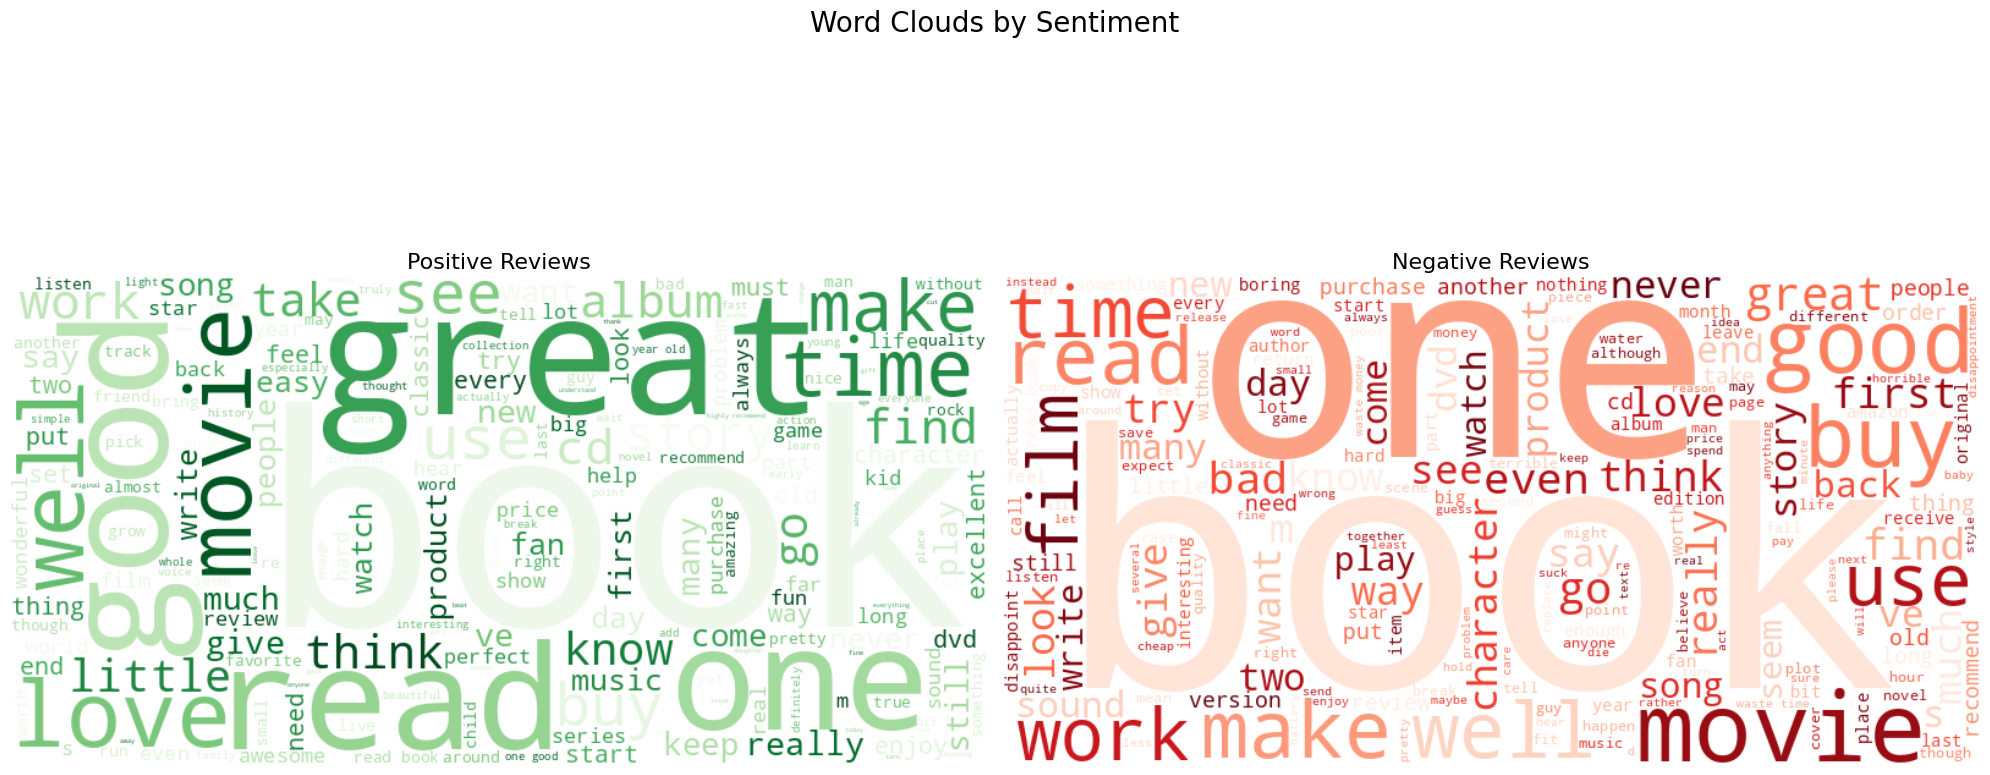

In [41]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Install wordcloud if not already installed
!pip install wordcloud -q

# Ensure 'full_text_lemmatized' and 'target' columns are available
if 'full_text_lemmatized' not in train_df.columns or 'target' not in train_df.columns:
    print("Error: 'full_text_lemmatized' or 'target' column not found. Please ensure data preprocessing has been performed.")
else:
    print("--- Generating Word Clouds for Positive and Negative Reviews ---")

    # The sentiment_map is {1: 'Negative', 2: 'Positive'}. Use numerical labels for filtering.
    # No need to define sentiment_map here if only using numerical values for filtering.
    # It's already defined and used in other cells, so we can directly use 1 and 2.

    # Combine all lemmatized positive reviews into a single string
    positive_reviews_text = ' '.join(train_df[train_df['target'] == 2]['full_text_lemmatized'].astype(str))

    # Combine all lemmatized negative reviews into a single string
    negative_reviews_text = ' '.join(train_df[train_df['target'] == 1]['full_text_lemmatized'].astype(str))

    # --- Generate Word Cloud for Positive Reviews ---
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_reviews_text)

    # --- Generate Word Cloud for Negative Reviews ---
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_reviews_text)

    # --- Visualize Word Clouds Side-by-Side ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('Word Clouds by Sentiment', fontsize=20)

    # Positive Word Cloud
    axes[0].imshow(wordcloud_positive, interpolation='bilinear')
    axes[0].set_title('Positive Reviews', fontsize=16)
    axes[0].axis('off')

    # Negative Word Cloud
    axes[1].imshow(wordcloud_negative, interpolation='bilinear')
    axes[1].set_title('Negative Reviews', fontsize=16)
    axes[1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    # Comments explaining how word clouds highlight dominant themes within each sentiment category:
    # - Word clouds visually represent the frequency of words in a text corpus, where larger words appear more frequently.
    # - By generating separate word clouds for positive and negative reviews, we can quickly grasp the key terms and concepts associated with each sentiment.
    # - **Positive Word Cloud:** Will highlight words that customers use when expressing satisfaction, praise, or positive experiences (e.g., 'great', 'love', 'easy', 'recommend'). These terms often relate to product benefits, good performance, or excellent service.
    # - **Negative Word Cloud:** Will emphasize words associated with dissatisfaction, complaints, or negative experiences (e.g., 'bad', 'waste', 'return', 'poor', 'not'). These terms often point to product flaws, poor value, or frustrating issues.
    # - This visual comparison offers an immediate, intuitive understanding of what drives positive versus negative customer feedback, complementing quantitative sentiment analysis and detailed linguistic insights.